# Task
do a sentiment analysis on this twitter data

Here is all the data you need:
"damn.csv"

## Data loading

### Subtask:
Load the twitter data from "damn.csv" into a pandas DataFrame.


**Reasoning**:
Load the data from "damn.csv" into a pandas DataFrame and display the first few rows and its shape.



In [ ]:
import pandas as pd

try:
    df = pd.read_csv('/content/indonesiagelap_sentiment - most_voted_sentiment-v1 (1).csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error: '/content/indonesiagelap_sentiment - most_voted_sentiment-v1 (1).csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Unable to parse '/content/indonesiagelap_sentiment - most_voted_sentiment-v1 (1).csv'. Check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,id,full_text,final_sentiment
0,0,@ARSIPAJA Menjijikan 3x Indonesia sampai punya...,negatif
1,1,@ARSIPAJA Macan ompong prajurit cepirit kacung...,negatif
2,2,Rakyat seolah hanya dibuat permainan dan leluc...,negatif
3,3,Duo Petaka Membawa Bencana #IndonesiaGelap,negatif
4,4,@krisiparuhbaya Poeeek mangg poeek literally #...,negatif


(2157, 3)


## Data cleaning

### Subtask:
Clean the text data in the 'full_text' column of the DataFrame.


**Reasoning**:
Clean the text data in the 'full_text' column by handling missing values, removing irrelevant characters, converting to lowercase, and optionally handling the 'Unnamed: 3' column.



In [ ]:
import re

# 1. Handle missing values
if df['full_text'].isnull().sum() > 0:
    df['full_text'].fillna('', inplace=True)  # Fill missing values with empty string
    print("Filled missing values in 'full_text' with empty strings.")
else:
    print("No missing values found in 'full_text'.")

# 2. Remove irrelevant characters
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    # Remove special characters (preserving emojis)
    text = re.sub(r'[^\w\s.,!?;:\-–—\'\"…()\[\]{}]', '', text)  # Keep some punctuations
    return text

df['full_text'] = df['full_text'].apply(clean_text)

# 3. Convert to lowercase
df['full_text'] = df['full_text'].str.lower()

# # 4. Handle 'Unnamed: 3' column (optional)
# if df['Unnamed: 3'].isnull().sum() / len(df) > 0.5:
#     # Drop the 'Unnamed: 3' column if more than 50% of values are missing
#     df.drop('Unnamed: 3', axis=1, inplace=True)
#     print("Dropped 'Unnamed: 3' column due to high percentage of missing values.")

display(df.head())

No missing values found in 'full_text'.


,id,full_text,final_sentiment
0,0,menjijikan 3x indonesia sampai punya presiden...,negatif
1,1,macan ompong prajurit cepirit kacung lancung....,negatif
2,2,rakyat seolah hanya dibuat permainan dan leluc...,negatif
3,3,duo petaka membawa bencana,negatif
4,4,poeeek mangg poeek literally,negatif


In [ ]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


## Data preparation

### Subtask:
Prepare the text data for sentiment analysis.


**Reasoning**:
Import necessary libraries and prepare the text data for sentiment analysis by removing stop words, performing lemmatization, and handling emojis.



**Reasoning**:
The previous code block failed due to a missing NLTK resource `punkt_tab`.  I will download this resource and then re-run the preprocessing code.



In [ ]:
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

def preprocess_text(text):
    # Remove emojis (replace with "EMOJI")
    text = re.sub(r'[^\x00-\x7F]+', 'EMOJI', text)

    # Remove stop words using Sastrawi
    text = stopword_remover.remove(text)

    # Stemming using Sastrawi
    text = stemmer.stem(text)

    # Tokenization and removing non-alphanumeric words
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.isalnum()]

    return " ".join(words)

df['processed_text'] = df['full_text'].apply(preprocess_text)

## Feature engineering

### Subtask:
Create numerical features from the preprocessed text data using TF-IDF.


**Reasoning**:
Create numerical features from the preprocessed text data using TF-IDF, and then concatenate the resulting TF-IDF features with the original dataframe.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform the processed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert to dense array
tfidf_array = tfidf_matrix.toarray()

# Create new DataFrame from tfidf array
df_tfidf = pd.DataFrame(tfidf_array, columns=tfidf_vectorizer.get_feature_names_out(), index=df.index)

# Concatenate with the original DataFrame
df = pd.concat([df, df_tfidf], axis=1)

display(df.head())

,id,full_text,final_sentiment,processed_text,00,00 orang,00 pm,00 wib,000,000 dm,...,zolim dosa,zolim sih,zolimi,zolimi sama,zon,zon jangan,zon kalau,zon patung,zon polda,zon sontoloyo
0,0,menjijikan 3x indonesia sampai punya presiden...,negatif,jijik 3x indonesia punya presiden begini,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,macan ompong prajurit cepirit kacung lancung....,negatif,macan ompong prajurit cepirit kacung lancung,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,rakyat seolah hanya dibuat permainan dan leluc...,negatif,rakyat hanya buat main lelucon perintah,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,duo petaka membawa bencana,negatif,duo petaka bawa bencana,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,poeeek mangg poeek literally,negatif,poeeek mangg poeek literally,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model training

### Subtask:
Train a Logistic Regression model for sentiment analysis.


**Reasoning**:
Train a Logistic Regression model for sentiment analysis using the TF-IDF features and the 'final_sentiment' column as the target variable.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Separate features (TF-IDF matrix) and target variable
X = df.drop(['id', 'full_text', 'final_sentiment', 'processed_text'], axis=1)
y = df['final_sentiment']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Now use X_resampled and y_resampled for training your model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Instantiate and train the Logistic Regression model
sentiment_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
sentiment_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Model evaluation

### Subtask:
Evaluate the trained Logistic Regression model.


**Reasoning**:
Evaluate the trained Logistic Regression model using the test data and print the evaluation metrics.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict the sentiment labels for the test data
y_pred = sentiment_model.predict(X_test)

# Calculate and print the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9213
Precision: 0.9230
Recall: 0.9213
F1-score: 0.9215
Confusion Matrix:
[[282  40   4]
 [ 21 301   0]
 [  6   6 318]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.91      0.87      0.89       326
      netral       0.87      0.93      0.90       322
     positif       0.99      0.96      0.98       330

    accuracy                           0.92       978
   macro avg       0.92      0.92      0.92       978
weighted avg       0.92      0.92      0.92       978



## Data analysis

### Subtask:
Analyze the overall sentiment distribution and identify any trends or patterns in the data.


**Reasoning**:
Predict the sentiment for each tweet using the trained model and analyze the sentiment distribution.



In [ ]:
# Predict sentiment for each tweet
df['predicted_sentiment'] = sentiment_model.predict(df.drop(['id', 'full_text', 'final_sentiment', 'processed_text'], axis=1))

# Analyze sentiment distribution
sentiment_counts = df['predicted_sentiment'].value_counts()
print("Sentiment Distribution:\n", sentiment_counts)

# Explore trends (example: if 'created_at' column exists)
if 'created_at' in df.columns:
    # Convert 'created_at' to datetime objects if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
        try:
            df['created_at'] = pd.to_datetime(df['created_at'])
        except ValueError:
            print("Error: Could not convert 'created_at' column to datetime objects.")
            # Handle the error gracefully, e.g., skip this analysis or use a different column
    else:
        # Group by day and calculate the average sentiment
        daily_sentiment = df.groupby(df['created_at'].dt.date)['predicted_sentiment'].value_counts(normalize=True).unstack()
        display(daily_sentiment)
        # Plot the trend (example plot)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        for col in daily_sentiment.columns:
            plt.plot(daily_sentiment.index, daily_sentiment[col], label=col)
        plt.xlabel("Date")
        plt.ylabel("Proportion of Sentiment")
        plt.title("Daily Sentiment Trend")
        plt.legend()
        plt.show()

# Explore potential correlations with other categorical features
# (example: if 'user_location' or 'topic' columns exist)
for col in ['user_location', 'topic']:  # Replace with actual column names
    if col in df.columns:
        location_sentiment = df.groupby(col)['predicted_sentiment'].value_counts(normalize=True).unstack()
        print(f"\nAverage Sentiment by {col}:\n", location_sentiment)

Sentiment Distribution:
 predicted_sentiment
negatif    1546
netral      419
positif     192
Name: count, dtype: int64


## Data visualization

### Subtask:
Visualize the sentiment distribution and explore potential trends over time (if applicable).


**Reasoning**:
Visualize the sentiment distribution using a bar chart and explore trends over time if a 'created_at' column exists and is in the correct format.



'created_at' column not found. Time series visualization skipped.


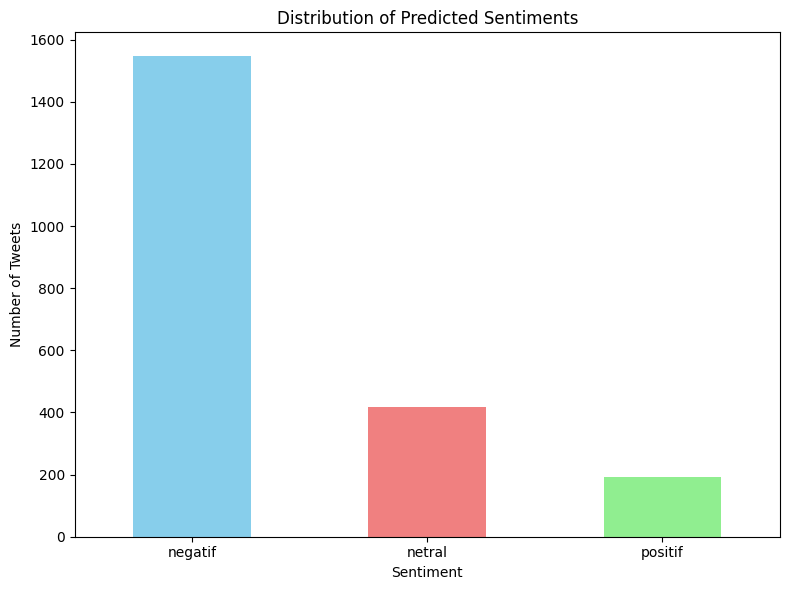

In [ ]:
import matplotlib.pyplot as plt

# 1. Sentiment Distribution Bar Chart
sentiment_counts = df['predicted_sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.tight_layout()


# 2. Time-Based Trends (if 'created_at' column exists and is valid)
if 'created_at' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
        try:
            df['created_at'] = pd.to_datetime(df['created_at'])
            daily_sentiment = df.groupby(df['created_at'].dt.date)['predicted_sentiment'].value_counts(normalize=True).unstack()
            plt.figure(figsize=(12, 6))
            for sentiment in ['negatif', 'netral', 'positif']:
                plt.plot(daily_sentiment.index, daily_sentiment[sentiment], label=sentiment)
            plt.xlabel('Date')
            plt.ylabel('Proportion of Tweets')
            plt.title('Sentiment Trend Over Time')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        except ValueError:
            print("Error: Could not convert 'created_at' column to datetime objects. Time series visualization skipped.")
    else:
        daily_sentiment = df.groupby(df['created_at'].dt.date)['predicted_sentiment'].value_counts(normalize=True).unstack()
        plt.figure(figsize=(12, 6))
        for sentiment in ['negatif', 'netral', 'positif']:
            plt.plot(daily_sentiment.index, daily_sentiment[sentiment], label=sentiment)
        plt.xlabel('Date')
        plt.ylabel('Proportion of Tweets')
        plt.title('Sentiment Trend Over Time')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("'created_at' column not found. Time series visualization skipped.")

plt.show()